##*Classifying Toxic Comments with BERT*
By Nakshatra Singh

This notebook will show you how to fine-tune BERT for *Toxic Comment Classification*.

##Using Google GPU for Training

Google colab offers free GPUs and TPUs! Since we'll be training a large model it's best to take advantage of this (in this case we'll use GPU), otherwise training can take long time.

A GPU can be added by going to the menu and selecting:

`Edit -> Notebook Settings -> Hardware Accelerator -> (GPU)`

Then run the following cell to confirm that a GPU is detected.

In [ ]:
import tensorflow as tf
# Get the device GPU name 
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
  print('Found GPU at : {}'.format(device_name)) 
else:
  raise SystemError('GPU not found!')

Found GPU at : /device:GPU:0


In order for torch to use GPU, we need to identify and specify the GPU as the device. Later, in our training loop, we will load data onto the device.

In [ ]:
import torch

# If there is a GPU available...
if torch.cuda.is_available():

  # Tell pytorch to use the GPU
  device = torch.device("cuda")

  print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
  print('No GPU available, using CPU instead')
  device = torch.device("cpu")

We will use the GPU: Tesla T4


###**1. Installing the Hugging Face library**

Next, let's install the *`transformers`* package from Hugging Face which will give us a pytorch interface to work with BERT. 

In [ ]:
!pip install transformers

     |████████████████████████████████| 778kB 4.5MB/s 
     |████████████████████████████████| 3.0MB 19.8MB/s 
     |████████████████████████████████| 890kB 54.2MB/s 
     |████████████████████████████████| 1.1MB 55.1MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=a59ba33b14b6a84f57b0dd074d51774019ddd9d34eed17b338dba657e20f7f20
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


###**2. Retrieve and Inspect Dataset**

Let's download the dataset which is uploaded on my google drive.

In [ ]:
!gdown --id 11Yk7Xh4iekxZM6yEwerfHicx0p5_JC7m 

Downloading...
From: https://drive.google.com/uc?id=11Yk7Xh4iekxZM6yEwerfHicx0p5_JC7m
To: /content/train.csv
68.8MB [00:00, 122MB/s]


We'll use `pandas` to parse the csv files.

In [ ]:
import pandas as pd
comments = pd.read_csv('/content/train.csv')

Let's take a look at the first few rows of the table just to see what's in there.

In [ ]:
comments.head() 

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [ ]:
comments.shape

(159571, 8)

Display some comments. Be prepared to see some terrible human behavior...

In [ ]:
import textwrap
import random
#wrap text to 100 characters.
wrapper = textwrap.TextWrapper(width=100)

#filter to just the 'toxic' comments.
toxic_examples = comments['comment_text']

#randomly choose some examples.
for i in range(5):
  j = random.choice(toxic_examples.index)

  print('')
  print(wrapper.fill(toxic_examples[j]))
  print('') 


"Welcome to Wikipedia, the free encyclopedia! You don't have to log in to read or edit articles on
Wikipedia, but creating an account is quick, free and non-intrusive, requires no personal
information, and gives you many benefits, including: The use of a username of your choice, provided
that it is appropriate. The ability to view all your contributions via a ""My contributions"" link.
Your own user page. Your own talk page which, if you choose, also allows users to send you messages
without knowing your e-mail address. The use of your own personal watchlist to which you can add
articles that interest you. The ability to start new pages. The ability to rename pages. The ability
to upload images. The ability to customize the appearance and behavior of the website. The
eligibility to become an administrator. The right to be heard in votes and elections. Your IP
address will no longer be visible to other users.  We hope you enjoy your time here on Wikipedia and
that you choose to become 

### **3. BERT Input Length Limitation**


BERT has a *maximum input length* of 512 tokens. In this section, we'll look at how this limitation affects us in practice, and some possible approaches for addressing it.

First, we'll load the BERT tokenizer.

In [ ]:
from transformers import BertTokenizer

# Load the BERT Tokenizer
print('Loading BERT Tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True) 

Loading BERT Tokenizer...


Let's see how the first comment in the dataset looks like.

In [ ]:
# Retrieve the text of the first comment.
text = comments.iloc[0].comment_text

# Run the tokenizer to count up the number of tokens. The tokenizer will split
# the text into words, punctuations, and subwords as needed.
tokens = tokenizer.tokenize(text)

print('Comment 0 contains {:,} WordPiece tokens.'.format(len(tokens)))
print('\nOriginal comment text:\n')
print(wrapper.fill(text))

Comment 0 contains 66 WordPiece tokens.

Original comment text:

Explanation Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't
vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove
the template from the talk page since I'm retired now.89.205.38.27


For our intuitive understanding we will only take 30000 samples. I tried training the model with the whole dataset, it spits an error: `CUDA out of memory`. So we'll be taking 30000 examples. I believe you can increase this to 70000 at max, if not just try a lower number.

In [ ]:
comments = comments.loc[:30000,:]
comments.shape

(30001, 8)

###**3.1 Strategies for Longer Text**

Key points:
- There is no obvious solution, but we'll cover a number of ideas to try.
- Looking at the statistics of your dataset should help when choosing your strategy

There was a [*paper published*](https://arxiv.org/abs/1905.05583) recently that investigated this problem and experimented with a few approaches. 

###3.1.1 Truncation
The simplest approach is to drop some of the tokens and hope that the remaining text is enough to perform the task well.

You can drop tokens:
- From the beginning of the text.
- At the end of the text.
- In the middle of the text.

In the above paper, their experiment on the IMDb movie review dataset showed that keeping the first 128 tokens and the last 382 tokens performed the best. (Note: This adds to 510 tokens, leaving room for the special `[CLS]` and `[SEP]` tokens that we have to append in the beginning and end of the text respectively.

*Visit section 5.3 in the paper for more details.*

###3.1.2 Chunking

Another approach attempted by the authors would be to divide the text into 512 token chunks and generate embeddings for these chunks seperately.

The authors of the paper combined the embeddings for the differnt chunks before performing the final classification. They tried several *pooling* strategies, such as averaging the embeddings together. None of these methods outperformed the simple truncation approach.


###3.1.3 Comment Length Distribution

To decide on a truncation strategy for this dataset, let's first look at the distribution comment lengths.

To do this, our first step is to tokenize all of the comments in the dataset.


###**Tokenize All Comments**
The `tokenizer.encode` function combines multiple steps for us:
1. Split the sentance into tokens.
2. Add special tokens `[CLS]` and `[SEP]` tokens.
3. Map the tokens to their IDs.

In order to explore the distribution of the comment lengths, we will not perform any truncation here. *`Unfortunately, this results in the tokenizer spitting out a warning for every comment that's longer than 512 tokens`*. We'll just have to ignore this for now.

In [ ]:
import numpy as np

# Tokenize all the sentences and map the tokens to their word IDs.
input_ids = [] 

# Record the length of each sequence (after truncating to 512).
lengths = []

# For every sentence...
for sen in comments.comment_text:

  # 'encode' will:
  # (1) Tokenize the sentence.
  # (2) Prepend the [CLS] token to the start.
  # (3) Append the [SEP] token to the end.
  # (4) Map tokens to their IDs.
  encode_sent = tokenizer.encode(
      sen,                       # Sentence to encode.
      add_special_tokens = True, # Add [CLS] and [SEP].
      #max_length = 512,         # Truncate all sentences to 512.
      #return_tensor = 'pt       # Return pytorch tensor.
  )
 
  # Add the encoded sentences to the list.
  input_ids.append(encode_sent)

  # Record the truncated length.
  lengths.append(len(encode_sent))

Token indices sequence length is longer than the specified maximum sequence length for this model (629 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (658 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (628 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1227 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (810 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for th

Before we continue, let's also retrieve the comment labels, and check out the class distribution for this dataset.

In [ ]:
# Get the labels from the dataframe and convert them to ints.
labels = comments.toxic.to_numpy().astype(int)

Let's grab some quick statistics- what are min, max and median comment lengths?

In [ ]:
print('    Min Length: {:,} tokens'.format(min(lengths)))
print('    Max Length: {:,} tokens'.format(max(lengths)))
print(' Median Length: {:,} tokens'.format(np.median(lengths)))

    Min Length: 4 tokens
    Max Length: 2,501 tokens
 Median Length: 52.0 tokens


To further analysis it, let's plot the distribution. To keep the scale of x-axis reasonable, we'll clip the lengths to 512.

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


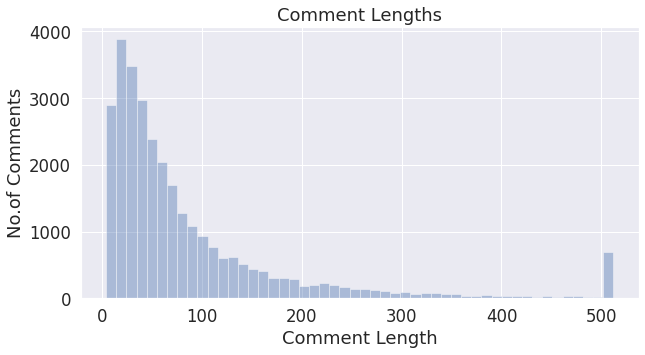

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='darkgrid')  

# Increase the plot size and font size
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (10, 5)

# Truncate any comment lengths greater than 512
lengths = [min(l, 512) for l in lengths]

# Plot the distribution of comment lengths.
sns.distplot(lengths, kde=False, rug=False)

# Label the plot.
plt.title('Comment Lengths')
plt.xlabel('Comment Length')
plt.ylabel('No.of Comments');

Clearly, most of the comments are "short", and there is a long tail of larger comments.

Just how many examples run into the 512 token limit?

In [ ]:
# Count the number of sentences that have been truncated to 512 tokens.
num_truncated = lengths.count(512)

# Compare this to the total number of training sentences.
num_sentences = len(lengths)

pcent = float(num_truncated) / float(num_sentences)

print('{:,} of {:,} sentences ({:.1%}) in the training set are longer than 512 tokens'.format(num_truncated, num_sentences, pcent))


664 of 30,001 sentences (2.2%) in the training set are longer than 512 tokens


###**4. Pad and Truncate the Comments**

I think it seems safe to truncate our comments to 512 tokens.

Not only that, I can think we can get away with an even shorter length to speed things up. i've picked the max length to 128, since this is around the elbow of the distribution.

We can also try longer lengths to see how much this improves the result.

In [ ]:
# We'll borrow the pad sequences utility fucntion to do this.
from keras.preprocessing.sequence import pad_sequences

# Set the required sentence length.
MAX_LEN = 128

# Pad our input tokens with value 0.
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", value=0, truncating="post", padding="post") 

###**5. Attention Masks**

The attention mask simply makes it explicit which tokens are actual versus which are paddings.

The BERT vocabulary does not use the ID 0, so if a ID is taken 0, then it's a padding, and otherwise it is a real token.

In [ ]:
# Create attention masks.
attention_masks = []

# For each sentence...
for sent in input_ids:
  # create the attention mask.
  # - if token ID is 0, then it's padding, so set the mask to 0.
  # - if token IS > 0, then it's a real token, so set the mask to 1.

  att_mask = [int(token_id > 0) for token_id in sent]

  # Store the attention masks for the sentences.
  attention_masks.append(att_mask)

###**6. Final Data Preparation**

1) Divide up our dataset to use 90% for training and 10% for validation.

In [ ]:
from sklearn.model_selection import train_test_split

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, random_state=2020, test_size=0.1)

# Do the same for masks.
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels, random_state=2021, test_size=0.1)

2) Our model exports Pytroch tensors rather than numpy.ndarrays, so let's convert all of our dataset variables.

In [ ]:
# Convert all our inputs and labels into torch tensors, the required datatype
# for our model.

train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

3) We'll also create an iterator for our dataset using torch DataLoader class. This helps us save memory during training because, unlike a for loop, with an iterator the entire dataset does not need to be loaded into memory.

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# The dataloader needs to know our batch size for training, so we specify it here.
# For fine-tuning BERT on a specific task, the authors recommend a batch size of
# 16 or 32.

batch_size = 32

# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler = train_sampler, batch_size = batch_size) 

# Create the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler = validation_sampler, batch_size=batch_size)

###**7. BERT Fine-Tuning**

#### Train our Classification Model:

Now that our input data is properly formatted, it's time to fine-tune the BERT model.

###*`7.1 BERTForSequenceClassification`*

For this task, we firstly want to modify the pre-trained BERT model to give outputs for classification, and then we want to continue training the model on our dataset until that the entire model end-to-end is well-suited for our task.

Thankfully, the huggingFace pytorch implementation includes a set of interfaces designed for a variety of NLP tasks. Here is the current list of classes provided for fine-tuning:
- BertModel
- BertForPretraining
- BertForMaskedLM
- BertForNextSentencePrediction
- BertForSequenceClassification
- BertForTokenClassification
- BertForQuestionAnswering

We'll use **BertForSequenceClassification**. *`This is the simple BERT model with an added single linear layer on top for classification that we will use as a sentence classifier`*. As we feed input data, the entire pre-trained BERT model and the additional untrained classification layer is trained on our specific task.

OK! Let's load the BERT model.

In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', # Use the 24 layer BERT model, with an uncased vocab.
                                                      num_labels =2, # The number of output labels --2 for binary classification, you can
                                                                     # increase this for multiclass tasks. 
                                                      output_attentions = False,    # whether the model returns attention weights.
                                                      output_hidden_states = False) # whether the model returns all hidden-states.
model.cuda() 

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

###*`7.2 Optimizers and Learning Rate Scheduler`*

Now that we have our model loaded we need to grab the training hyperparamters from within the stored model.

For the purpose of fine-tuning, the authors have recommended choosing from the following values:
- Batch size: 16, 32 (we chose 32 when creating the dataloader)
- Learning Rate (Adam): 5e-5, 3e-5, 2e-5 (we'll use 2e-5)
- Number of Epochs: 2, 3, 4 (we'll use 4)




In [ ]:
# Note: AdamW is a class from huggingface library (as opposed to pytorch).
# I believe the 'W' stands for weight decay fix.

optimizer = AdamW(model.parameters(), 
                  lr = 2e-5,
                  eps = 1e-8)

In [ ]:
from transformers import get_linear_schedule_with_warmup

epochs = 4

total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

###*`7.3 Training Loop`*

Define a helper function for calculating accuracy.

In [ ]:
def flat_accuracy(preds, labels):
  pred_flat = np.argmax(preds, axis=1).flatten()
  labels_flat = labels.flatten()
  return np.sum(pred_flat == labels_flat) / len(labels_flat) 

Define a helper function for formatting elapsed time.

In [ ]:
import time 
import datetime

def format_time(elapsed):
  elapsed_rounded = int(round((elapsed)))

  return str(datetime.timedelta(seconds=elapsed_rounded))

We are ready to kickstart the training!!!!

In [ ]:
import random

# Set the seed value all over the place to make it reproducible.
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store average loss after each epoch so we can plot them.
loss_values = []

# For each epoch...
for epoch_i in range(0, epochs):

  print("")
  print('========== EPOCH {:} / {:} =========='.format(epoch_i + 1, epochs))
  print('Training.....')

  #Measure how long the training epoch took.
  t0 = time.time() 

  #Reset the total loss for this epoch.
  total_loss = 0
  
  #Dont be mislead the train cll just changes the mode.
  model.train()

  for step, batch in enumerate(train_dataloader):

    if step%100 == 0 and not step ==0:
      elapsed = format_time(time.time() - t0)

      print('  Batch {:>5,} of {:>5,}  Elasped : {:}.'.format(step, len(train_dataloader), elapsed))

    # Unpack this training batch from our dataloader.
    # As we unpack the batch, we'll also copy each copy to the GPU using the 
    # .to methdod.

    # Batch contains three pytorch tensors:
    # [0]: input_ids
    # [1]: attention_masks
    # [2]: labels
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)

    # Always clear any previously calculated gradients before performing a
    # backward pass. Pytorch doesn't do this automatically because
    # accumilating the gradients is "convenient while training RNNs"

    model.zero_grad() 

    # perform a forward pass (evaluate the model on this training batch).
    # This will return the loss (rather than model output) because we have 
    # provided the labels.

    outputs = model(b_input_ids,
                      token_type_ids=None,
                      attention_mask=b_input_mask,
                      labels = b_labels)  
      
    #The call to 'model' always returns a tuple, so we need to pull the loss 
    # value out of the tuple.

    loss = outputs[0]

    # Accumulate the training loss over all of the batches so that we can 
    # calculate the average loss at the end. 'Loss' is a tensor containing a
    # single value; the '.item()' function just returns the python value
    # from the tensor.

    total_loss += loss.item()

    # perform a backward pass to calculate the gradients.
    loss.backward() 

    # clip the norm of the gradients to 1.0.
    # this is to help prevent the 'exploding gradient' problem.

    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # Update parameters and take a step using the computed gradient.
    # The optimizer dictates the 'update rule' -- how the parameters
    # are modified based on their gradients, the learning rate, etc.
    optimizer.step()

    #update learning rate.
    scheduler.step()

  # calculate the average loss over the training data.
  avg_train_loss = total_loss/ len(train_dataloader)

  # store the loss values for plotting the learning curve.
  loss_values.append(avg_train_loss)

  print("")
  print("  Average training loss: {0:.2f}".format(avg_train_loss))
  print("  Training Epoch took: {:}".format(format_time(time.time() - t0)))

  # =====================================
  #             Validation
  # =====================================
  # After the completion of each training epoch, measure our performance on
  # our validation set.


  print("")
  print("Running Validation.....")

  #Measure how long the validation epoch took.
  t0 = time.time()

  # Putting the model in evaluation mode --dropout layers behave differntly 
  #during evaluation.
  model.eval()

  # Tracking variables.
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  # Evaluate data for one epoch.
  for batch in validation_dataloader:

    #Add batch to GPU.
    batch = tuple(t.to(device) for t in batch)

    #unpack the inputs from our dataloader.
    b_input_ids, b_input_mask, b_labels = batch
    
    #telling the model not to compute or store gradients, saving memory and
    # speeding up validation.
    with torch.no_grad():
      # Forward pass, calculate logit predictions.
      # This will return the logits rather than loss because we have not
      # provided the labels.
      # token_type_ids is same as the "segment ids", which differntiates
      # sentence 1 and sentence 2 in 2-sentance tasks.
      outputs = model(b_input_ids,
                      token_type_ids=None,
                      attention_mask=b_input_mask)
      
    # Get the 'logits' output from the model. The logits are the output values
    # prior to applying an activation function like the softmax.
    logits = outputs[0]

    #Move logits and labels to CPU.
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    #Calculate the accuracy for this batch of test sentences.
    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    
    # Accumulate the total accuracy.
    eval_accuracy += tmp_eval_accuracy

    # Track the number of batches.
    nb_eval_steps += 1

  # Report the final accuracy for this validation run.
  print(" Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
  print(" validation took: {:}".format(format_time(time.time() - t0))) 

print("")
print("Training Completed!")


========== EPOCH 1 / 4 ==========
Training.....
  Batch   100 of   844  Elasped : 0:01:11.
  Batch   200 of   844  Elasped : 0:02:21.
  Batch   300 of   844  Elasped : 0:03:30.
  Batch   400 of   844  Elasped : 0:04:40.
  Batch   500 of   844  Elasped : 0:05:50.
  Batch   600 of   844  Elasped : 0:07:00.
  Batch   700 of   844  Elasped : 0:08:09.
  Batch   800 of   844  Elasped : 0:09:19.

  Average training loss: 0.15
  Training Epoch took: 0:09:50

Running Validation.....
 Accuracy: 0.95
 validation took: 0:00:23

========== EPOCH 2 / 4 ==========
Training.....
  Batch   100 of   844  Elasped : 0:01:10.
  Batch   200 of   844  Elasped : 0:02:19.
  Batch   300 of   844  Elasped : 0:03:29.
  Batch   400 of   844  Elasped : 0:04:38.
  Batch   500 of   844  Elasped : 0:05:48.
  Batch   600 of   844  Elasped : 0:06:57.
  Batch   700 of   844  Elasped : 0:08:07.
  Batch   800 of   844  Elasped : 0:09:17.

  Average training loss: 0.09
  Training Epoch took: 0:09:48

Running Validation....

Let's take a look at our training loss over all batches.

Text(0, 0.5, 'Loss')

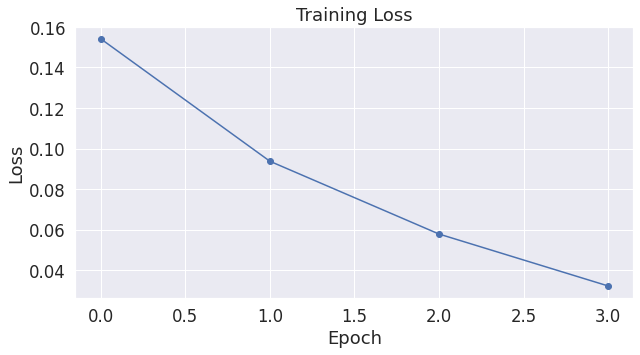

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

sns.set(style='darkgrid')  

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (10, 5)

# Plot the learning curve.
plt.plot(loss_values, 'b-o')

#Label the plot.
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss");